用不同长度的轨迹训练自编码器

长度：3s

方法：单向重构

---


In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T8PIAE1, Vehicle_Model_Methods
import numpy as np

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [2]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/data/data3s'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_data.kpl'))
val_data = load_preprocessed_data(os.path.join(input_file,'val_data.kpl'))
dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[2],tarin_data[3])

dataloader = DataLoader(dataset, batch_size=600, shuffle=True)

val_feat = val_data[0].to(device)
val_edagepoint = val_data[1].to(device)
val_endstate = val_data[2].to(device)
val_label = val_data[3].to(device)

In [3]:

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,outputs, targets, actions):

        mse_loss = nn.MSELoss()(outputs, targets)

        # 平滑loss
        ax = actions[:, :, 0]
        delta = actions[:, :, 1]

        loss_ax = torch.mean(torch.abs(torch.diff(ax,dim=1)))
        loss_delta = torch.mean(torch.abs(torch.diff(delta,dim=1)))*10
    
        return mse_loss + 1e-3*(loss_ax+loss_delta)

In [4]:

# 3. 定义模型、损失函数和优化器
#模型
model = T8PIAE1(torch.tensor(10),torch.tensor(0.25),t_len=30)

# 损失函数
criterion = nn.MSELoss()
criterion_train = CustomLoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

model.to(device)


T8PIAE1(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=58, out_features=1200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1200, out_features=600, bias=True)
    (4): ReLU()
  )
  (encoder_ax): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=28, bias=True)
    (3): Tanh()
  )
  (encoder_delta): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=28, bias=True)
    (3): Tanh()
  )
)

In [5]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/logs/log5')


# 4. 训练模型Autoencoder
epochs = 900

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (feat,edagepoint,endstate,label) in enumerate(dataloader):  
        
        label = label.to(device)  # 将输入数据移动到同一设备
        feat = feat.to(device)
        edagepoint = edagepoint.to(device)
        endstate = endstate.to(device)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion_train(outputs, label,actions)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task4_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task5_model_best.pth')
        best_loss = val_loss.item()


    print(f'\rEpoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()} ')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


Epoch 1, Train Loss: 0.04670916870236397, Val Loss: 0.04793250560760498 


Epoch 2, Train Loss: 0.028476720675826073, Val Loss: 0.04430171474814415 


Epoch 3, Train Loss: 0.038411423563957214, Val Loss: 0.03954382985830307 


Epoch 4, Train Loss: 0.05197717994451523, Val Loss: 0.04481503367424011 


Epoch 5, Train Loss: 0.013066460378468037, Val Loss: 0.016071593388915062 


Epoch 6, Train Loss: 0.010755408555269241, Val Loss: 0.028862765058875084 


Epoch 7, Train Loss: 0.01596723683178425, Val Loss: 0.017419256269931793 


Epoch 8, Train Loss: 0.035211898386478424, Val Loss: 0.020714011043310165 


Epoch 9, Train Loss: 0.009157012216746807, Val Loss: 0.011552450247108936 


Epoch 10, Train Loss: 0.004622361157089472, Val Loss: 0.010858372785151005 


Epoch 11, Train Loss: 0.013037185184657574, Val Loss: 0.010377376340329647 


Epoch 12, Train Loss: 0.006287290249019861, Val Loss: 0.008557810448110104 


Epoch 13, Train Loss: 0.027029462158679962, Val Loss: 0.019655587151646614 


Epoch 14, Train Loss: 0.008547167293727398, Val Loss: 0.010846421122550964 


Epoch 15, Train Loss: 0.005584754049777985, Val Loss: 0.010130545124411583 


Epoch 16, Train Loss: 0.005652023479342461, Val Loss: 0.010447044856846333 


Epoch 17, Train Loss: 0.0230870321393013, Val Loss: 0.013864681124687195 


Epoch 18, Train Loss: 0.0059140026569366455, Val Loss: 0.008115189149975777 


Epoch 19, Train Loss: 0.003843562211841345, Val Loss: 0.008811285719275475 


Epoch 20, Train Loss: 0.004034566227346659, Val Loss: 0.00742090679705143 


Epoch 21, Train Loss: 0.008371521718800068, Val Loss: 0.007875562645494938 


Epoch 22, Train Loss: 0.014517283998429775, Val Loss: 0.008183959871530533 


Epoch 23, Train Loss: 0.011336229741573334, Val Loss: 0.015814991667866707 


Epoch 24, Train Loss: 0.0039550261572003365, Val Loss: 0.007337623741477728 


Epoch 25, Train Loss: 0.006738211028277874, Val Loss: 0.007609858643263578 


Epoch 26, Train Loss: 0.005236371420323849, Val Loss: 0.009363500401377678 


Epoch 27, Train Loss: 0.01905220001935959, Val Loss: 0.012079776264727116 


Epoch 28, Train Loss: 0.004189427010715008, Val Loss: 0.008992482908070087 


Epoch 29, Train Loss: 0.01594134420156479, Val Loss: 0.01623697765171528 


Epoch 30, Train Loss: 0.008128310553729534, Val Loss: 0.01708281971514225 


Epoch 31, Train Loss: 0.015177270397543907, Val Loss: 0.012373990379273891 


Epoch 32, Train Loss: 0.005972747225314379, Val Loss: 0.009432823397219181 


Epoch 33, Train Loss: 0.007861088030040264, Val Loss: 0.008299409411847591 


Epoch 34, Train Loss: 0.008859260939061642, Val Loss: 0.012015054002404213 


Epoch 35, Train Loss: 0.020571822300553322, Val Loss: 0.01756945438683033 


Epoch 36, Train Loss: 0.00993376411497593, Val Loss: 0.018615886569023132 


Epoch 37, Train Loss: 0.004597926512360573, Val Loss: 0.007299952208995819 


Epoch 38, Train Loss: 0.010142895393073559, Val Loss: 0.011799599975347519 


Epoch 39, Train Loss: 0.005943160969763994, Val Loss: 0.008451093919575214 


Epoch 40, Train Loss: 0.005758303217589855, Val Loss: 0.012155608274042606 


Epoch 41, Train Loss: 0.01829639822244644, Val Loss: 0.014668121002614498 


Epoch 42, Train Loss: 0.005986860021948814, Val Loss: 0.009511483833193779 


Epoch 43, Train Loss: 0.0034878700971603394, Val Loss: 0.006253209430724382 


Epoch 44, Train Loss: 0.0072319949977099895, Val Loss: 0.012099460698664188 


Epoch 45, Train Loss: 0.012217535637319088, Val Loss: 0.010078348219394684 


Epoch 46, Train Loss: 0.003479575738310814, Val Loss: 0.00633038766682148 


Epoch 47, Train Loss: 0.009490935131907463, Val Loss: 0.009680352173745632 


Epoch 48, Train Loss: 0.004641245119273663, Val Loss: 0.007451222278177738 


Epoch 49, Train Loss: 0.015484949573874474, Val Loss: 0.007109483238309622 


Epoch 50, Train Loss: 0.005795679986476898, Val Loss: 0.011540153063833714 


Epoch 51, Train Loss: 0.005961614660918713, Val Loss: 0.006793952081352472 


Epoch 52, Train Loss: 0.006018787622451782, Val Loss: 0.007089134771376848 


Epoch 53, Train Loss: 0.0034313215874135494, Val Loss: 0.009057027287781239 


Epoch 54, Train Loss: 0.055963970720767975, Val Loss: 0.006822568830102682 


Epoch 55, Train Loss: 0.0055543589405715466, Val Loss: 0.008830382488667965 


Epoch 56, Train Loss: 0.0028365098405629396, Val Loss: 0.007017832715064287 


Epoch 57, Train Loss: 0.0030319727957248688, Val Loss: 0.0074410270899534225 


Epoch 58, Train Loss: 0.00426484365016222, Val Loss: 0.007742876186966896 


Epoch 59, Train Loss: 0.006611824966967106, Val Loss: 0.012459506280720234 


Epoch 60, Train Loss: 0.005098599940538406, Val Loss: 0.005576588213443756 


Epoch 61, Train Loss: 0.018875254318118095, Val Loss: 0.011220619082450867 


Epoch 62, Train Loss: 0.0029442475643008947, Val Loss: 0.005803041160106659 


Epoch 63, Train Loss: 0.009437855333089828, Val Loss: 0.012206160463392735 


Epoch 64, Train Loss: 0.007825040258467197, Val Loss: 0.01644999347627163 


Epoch 65, Train Loss: 0.013020360842347145, Val Loss: 0.011780135333538055 


Epoch 66, Train Loss: 0.008583152666687965, Val Loss: 0.0086214579641819 


Epoch 67, Train Loss: 0.005228651687502861, Val Loss: 0.0076813106425106525 


Epoch 68, Train Loss: 0.0033082198351621628, Val Loss: 0.00771882850676775 


Epoch 69, Train Loss: 0.004225274547934532, Val Loss: 0.007339345291256905 


Epoch 70, Train Loss: 0.0033181332983076572, Val Loss: 0.0076421755366027355 


Epoch 71, Train Loss: 0.003512535709887743, Val Loss: 0.00840295385569334 


Epoch 72, Train Loss: 0.003297607647255063, Val Loss: 0.006251007784157991 


Epoch 73, Train Loss: 0.0032007312402129173, Val Loss: 0.0073714470490813255 


Epoch 74, Train Loss: 0.008319453336298466, Val Loss: 0.00587052246555686 


Epoch 75, Train Loss: 0.005777164828032255, Val Loss: 0.006075199693441391 


Epoch 76, Train Loss: 0.00533519359305501, Val Loss: 0.007255556993186474 


Epoch 77, Train Loss: 0.0025326150935143232, Val Loss: 0.00630165683105588 


Epoch 78, Train Loss: 0.00475519010797143, Val Loss: 0.00762579869478941 


Epoch 79, Train Loss: 0.01112496666610241, Val Loss: 0.012311090715229511 


Epoch 80, Train Loss: 0.012852923944592476, Val Loss: 0.008282031863927841 


Epoch 81, Train Loss: 0.01126457005739212, Val Loss: 0.014362975023686886 


Epoch 82, Train Loss: 0.005238916724920273, Val Loss: 0.008594726212322712 


Epoch 83, Train Loss: 0.003384160343557596, Val Loss: 0.005949533544480801 


Epoch 84, Train Loss: 0.009138830937445164, Val Loss: 0.00921284593641758 


Epoch 85, Train Loss: 0.005848838482052088, Val Loss: 0.006083664484322071 


Epoch 86, Train Loss: 0.0916539654135704, Val Loss: 0.0078953942283988 


Epoch 87, Train Loss: 0.0025838559959083796, Val Loss: 0.005124283023178577 


Epoch 88, Train Loss: 0.009380060248076916, Val Loss: 0.006372983567416668 


Epoch 89, Train Loss: 0.002945267828181386, Val Loss: 0.00908387266099453 


Epoch 90, Train Loss: 0.004330819472670555, Val Loss: 0.00776358088478446 


Epoch 91, Train Loss: 0.003753816243261099, Val Loss: 0.008587918244302273 


Epoch 92, Train Loss: 0.0022937958128750324, Val Loss: 0.0072930604219436646 


Epoch 93, Train Loss: 0.006655452772974968, Val Loss: 0.008295954205095768 


Epoch 94, Train Loss: 0.006832932122051716, Val Loss: 0.009031204506754875 


Epoch 95, Train Loss: 0.0073686521500349045, Val Loss: 0.006371065508574247 


Epoch 96, Train Loss: 0.00753822922706604, Val Loss: 0.005836972501128912 


Epoch 97, Train Loss: 0.07881700992584229, Val Loss: 0.02727542631328106 


Epoch 98, Train Loss: 0.0061922334134578705, Val Loss: 0.010681668296456337 


Epoch 99, Train Loss: 0.005380991846323013, Val Loss: 0.005987921264022589 


Epoch 100, Train Loss: 0.005182595457881689, Val Loss: 0.006196658592671156 


Epoch 101, Train Loss: 0.004883157089352608, Val Loss: 0.005771241150796413 


Epoch 102, Train Loss: 0.00458498066291213, Val Loss: 0.005365821532905102 


Epoch 103, Train Loss: 0.0024549965746700764, Val Loss: 0.006202334072440863 


Epoch 104, Train Loss: 0.0065298182889819145, Val Loss: 0.010538040660321712 


Epoch 105, Train Loss: 0.010017292574048042, Val Loss: 0.0082280607894063 


Epoch 106, Train Loss: 0.008363904431462288, Val Loss: 0.009492541663348675 


Epoch 107, Train Loss: 0.008783131837844849, Val Loss: 0.009622887708246708 


Epoch 108, Train Loss: 0.004014163743704557, Val Loss: 0.006407482083886862 


Epoch 109, Train Loss: 0.005260774400085211, Val Loss: 0.007112204562872648 


Epoch 110, Train Loss: 0.0055322120897471905, Val Loss: 0.0057195015251636505 


Epoch 111, Train Loss: 0.010130073875188828, Val Loss: 0.005070948041975498 


Epoch 112, Train Loss: 0.011509455740451813, Val Loss: 0.008293049409985542 


Epoch 113, Train Loss: 0.008160259574651718, Val Loss: 0.01121436059474945 


Epoch 114, Train Loss: 0.008618720807135105, Val Loss: 0.008658189326524734 


Epoch 115, Train Loss: 0.0050216675736010075, Val Loss: 0.009159140288829803 


Epoch 116, Train Loss: 0.002402365207672119, Val Loss: 0.00615067919716239 


Epoch 117, Train Loss: 0.0020941575057804585, Val Loss: 0.004933750722557306 


Epoch 118, Train Loss: 0.0024193592835217714, Val Loss: 0.005741499364376068 


Epoch 119, Train Loss: 0.004542087204754353, Val Loss: 0.007184329442679882 


Epoch 120, Train Loss: 0.005248732399195433, Val Loss: 0.009235940873622894 


Epoch 121, Train Loss: 0.0016366380732506514, Val Loss: 0.005907037295401096 


Epoch 122, Train Loss: 0.0023891120217740536, Val Loss: 0.005173095501959324 


Epoch 123, Train Loss: 0.0027590389363467693, Val Loss: 0.007990967482328415 


Epoch 124, Train Loss: 0.002212679013609886, Val Loss: 0.006182168144732714 


Epoch 125, Train Loss: 0.0032792286947369576, Val Loss: 0.006477690767496824 


Epoch 126, Train Loss: 0.0036403031554073095, Val Loss: 0.006291690748184919 


Epoch 127, Train Loss: 0.00243282038718462, Val Loss: 0.006283896043896675 


Epoch 128, Train Loss: 0.003153134835883975, Val Loss: 0.006672021932899952 


Epoch 129, Train Loss: 0.0030070266220718622, Val Loss: 0.0062057850882411 


Epoch 130, Train Loss: 0.0021130910608917475, Val Loss: 0.007917583920061588 


Epoch 131, Train Loss: 0.004496176727116108, Val Loss: 0.00800326094031334 


Epoch 132, Train Loss: 0.006246546283364296, Val Loss: 0.007778245955705643 


Epoch 133, Train Loss: 0.0029896816704422235, Val Loss: 0.006945847533643246 


Epoch 134, Train Loss: 0.002169140847399831, Val Loss: 0.006996148731559515 


Epoch 135, Train Loss: 0.006003210321068764, Val Loss: 0.008226851001381874 


Epoch 136, Train Loss: 0.0041311923414468765, Val Loss: 0.0050025442615151405 


Epoch 137, Train Loss: 0.0039010304026305676, Val Loss: 0.0076127261854708195 


Epoch 138, Train Loss: 0.003230347763746977, Val Loss: 0.005171873606741428 


Epoch 139, Train Loss: 0.003207588102668524, Val Loss: 0.004769572522491217 


Epoch 140, Train Loss: 0.002977340715005994, Val Loss: 0.0055210404098033905 


Epoch 141, Train Loss: 0.0062433574348688126, Val Loss: 0.007321332581341267 


Epoch 142, Train Loss: 0.004716919735074043, Val Loss: 0.008213536813855171 


Epoch 143, Train Loss: 0.003383223433047533, Val Loss: 0.007017387077212334 


Epoch 144, Train Loss: 0.008446800522506237, Val Loss: 0.012669065967202187 


Epoch 145, Train Loss: 0.004399130120873451, Val Loss: 0.007716156542301178 


Epoch 146, Train Loss: 0.008229769766330719, Val Loss: 0.01276340987533331 


Epoch 147, Train Loss: 0.0072104535065591335, Val Loss: 0.00657766405493021 


Epoch 148, Train Loss: 0.0035414656158536673, Val Loss: 0.005179857835173607 


Epoch 149, Train Loss: 0.0060636019334197044, Val Loss: 0.00581634696573019 


Epoch 150, Train Loss: 0.006966729648411274, Val Loss: 0.008211462758481503 


Epoch 151, Train Loss: 0.0021765530109405518, Val Loss: 0.005671320483088493 


Epoch 152, Train Loss: 0.0042043630965054035, Val Loss: 0.00737904803827405 


Epoch 153, Train Loss: 0.004666552878916264, Val Loss: 0.004790767095983028 


Epoch 154, Train Loss: 0.0020209169015288353, Val Loss: 0.005246508400887251 


Epoch 155, Train Loss: 0.002235227497294545, Val Loss: 0.005170156247913837 


Epoch 156, Train Loss: 0.006593659054487944, Val Loss: 0.006079900544136763 


Epoch 157, Train Loss: 0.004209745675325394, Val Loss: 0.006514039821922779 


Epoch 158, Train Loss: 0.003059117356315255, Val Loss: 0.006323105655610561 


Epoch 159, Train Loss: 0.002642422216013074, Val Loss: 0.004506245721131563 


Epoch 160, Train Loss: 0.008750563487410545, Val Loss: 0.01013496145606041 


Epoch 161, Train Loss: 0.0021958183497190475, Val Loss: 0.005885004997253418 


Epoch 162, Train Loss: 0.00729381712153554, Val Loss: 0.008244538679718971 


Epoch 163, Train Loss: 0.0031590035650879145, Val Loss: 0.006735124625265598 


Epoch 164, Train Loss: 0.0050278520211577415, Val Loss: 0.005770405288785696 


Epoch 165, Train Loss: 0.0022101232316344976, Val Loss: 0.005426463205367327 


Epoch 166, Train Loss: 0.00303942384198308, Val Loss: 0.007215240970253944 


Epoch 167, Train Loss: 0.003353293053805828, Val Loss: 0.005878958851099014 


Epoch 168, Train Loss: 0.002676689764484763, Val Loss: 0.007417908404022455 


Epoch 169, Train Loss: 0.003912575542926788, Val Loss: 0.005734282545745373 


Epoch 170, Train Loss: 0.004286918323487043, Val Loss: 0.005253141280263662 


Epoch 171, Train Loss: 0.0028554964810609818, Val Loss: 0.005032604560256004 


Epoch 172, Train Loss: 0.004410907160490751, Val Loss: 0.005720008630305529 


Epoch 173, Train Loss: 0.002564783440902829, Val Loss: 0.005114802625030279 


Epoch 174, Train Loss: 0.003430339740589261, Val Loss: 0.005683679133653641 


Epoch 175, Train Loss: 0.0027524512261152267, Val Loss: 0.006007691379636526 


Epoch 176, Train Loss: 0.004271841607987881, Val Loss: 0.006535694003105164 


Epoch 177, Train Loss: 0.004168167244642973, Val Loss: 0.007500348147004843 


Epoch 178, Train Loss: 0.002839348977431655, Val Loss: 0.006084928754717112 


Epoch 179, Train Loss: 0.0036082796286791563, Val Loss: 0.009304524399340153 


Epoch 180, Train Loss: 0.008495223708450794, Val Loss: 0.013002687133848667 


Epoch 181, Train Loss: 0.00553665217012167, Val Loss: 0.007264267653226852 


Epoch 182, Train Loss: 0.007889624685049057, Val Loss: 0.005415158811956644 


Epoch 183, Train Loss: 0.004469871520996094, Val Loss: 0.006041551474481821 


Epoch 184, Train Loss: 0.0018401279812678695, Val Loss: 0.008608185686171055 


Epoch 185, Train Loss: 0.005709234159439802, Val Loss: 0.006961131002753973 


Epoch 186, Train Loss: 0.01721169427037239, Val Loss: 0.007681496907025576 


Epoch 187, Train Loss: 0.003745788475498557, Val Loss: 0.0066886600106954575 


Epoch 188, Train Loss: 0.004503244534134865, Val Loss: 0.007830922491848469 


Epoch 189, Train Loss: 0.002435544738546014, Val Loss: 0.005372412037104368 


Epoch 190, Train Loss: 0.004025680013000965, Val Loss: 0.006576129700988531 


Epoch 191, Train Loss: 0.004036509431898594, Val Loss: 0.005951832979917526 


Epoch 192, Train Loss: 0.00483444519340992, Val Loss: 0.0073192911222577095 


Epoch 193, Train Loss: 0.015075050294399261, Val Loss: 0.023024465888738632 


Epoch 194, Train Loss: 0.00504733482375741, Val Loss: 0.006193395704030991 


Epoch 195, Train Loss: 0.0017564124427735806, Val Loss: 0.005909380037337542 


Epoch 196, Train Loss: 0.006606004666537046, Val Loss: 0.009962964802980423 


Epoch 197, Train Loss: 0.0025448387023061514, Val Loss: 0.006768290419131517 


Epoch 198, Train Loss: 0.006101910024881363, Val Loss: 0.004772828426212072 


Epoch 199, Train Loss: 0.00642616581171751, Val Loss: 0.005304329562932253 


Epoch 200, Train Loss: 0.004232108127325773, Val Loss: 0.00627598911523819 


Epoch 201, Train Loss: 0.006111431401222944, Val Loss: 0.00742573756724596 


Epoch 202, Train Loss: 0.002595049561932683, Val Loss: 0.005292103625833988 


Epoch 203, Train Loss: 0.014237730763852596, Val Loss: 0.006996904034167528 


Epoch 204, Train Loss: 0.0031428984366357327, Val Loss: 0.006140333600342274 


Epoch 205, Train Loss: 0.003968921024352312, Val Loss: 0.008369299583137035 


Epoch 206, Train Loss: 0.02293247915804386, Val Loss: 0.014250346459448338 


Epoch 207, Train Loss: 0.0029397434554994106, Val Loss: 0.0063916537910699844 


Epoch 208, Train Loss: 0.008271310478448868, Val Loss: 0.009284166619181633 


Epoch 209, Train Loss: 0.0032263598404824734, Val Loss: 0.004720255732536316 


Epoch 210, Train Loss: 0.003796403994783759, Val Loss: 0.0063662221655249596 


Epoch 211, Train Loss: 0.011280308477580547, Val Loss: 0.005901135038584471 


Epoch 212, Train Loss: 0.00798233412206173, Val Loss: 0.009621597826480865 


Epoch 213, Train Loss: 0.0027479042764753103, Val Loss: 0.005424373783171177 


Epoch 214, Train Loss: 0.002175982343032956, Val Loss: 0.0040606241673231125 


Epoch 215, Train Loss: 0.003064611926674843, Val Loss: 0.006427191197872162 


Epoch 216, Train Loss: 0.0018787151202559471, Val Loss: 0.004238528199493885 


Epoch 217, Train Loss: 0.0033022749703377485, Val Loss: 0.005377310328185558 


Epoch 218, Train Loss: 0.002156858565285802, Val Loss: 0.0042571029625833035 


Epoch 219, Train Loss: 0.004229522775858641, Val Loss: 0.004977463278919458 


Epoch 220, Train Loss: 0.0025378090795129538, Val Loss: 0.0054380279034376144 


Epoch 221, Train Loss: 0.010237677954137325, Val Loss: 0.004449756816029549 


Epoch 222, Train Loss: 0.011155866086483002, Val Loss: 0.005303772632032633 


Epoch 223, Train Loss: 0.06186765059828758, Val Loss: 0.007249509450048208 


Epoch 224, Train Loss: 0.002620919141918421, Val Loss: 0.005366392899304628 


Epoch 225, Train Loss: 0.01019889023154974, Val Loss: 0.005572741385549307 


Epoch 226, Train Loss: 0.0019280740525573492, Val Loss: 0.005491430405527353 


Epoch 227, Train Loss: 0.00470508961006999, Val Loss: 0.005989674478769302 


Epoch 228, Train Loss: 0.003887174418196082, Val Loss: 0.006590631790459156 


Epoch 229, Train Loss: 0.0035701938904821873, Val Loss: 0.00567650469020009 


Epoch 230, Train Loss: 0.0026568803004920483, Val Loss: 0.006987863685935736 


Epoch 231, Train Loss: 0.002061277162283659, Val Loss: 0.005257970187813044 


Epoch 232, Train Loss: 0.0040762415155768394, Val Loss: 0.005871185101568699 


Epoch 233, Train Loss: 0.006834258791059256, Val Loss: 0.010436012409627438 


Epoch 234, Train Loss: 0.0025298907421529293, Val Loss: 0.00503035681322217 


Epoch 235, Train Loss: 0.0029134531505405903, Val Loss: 0.007548381108790636 


Epoch 236, Train Loss: 0.0026055306661874056, Val Loss: 0.005006175953894854 


Epoch 237, Train Loss: 0.009015047922730446, Val Loss: 0.007468902971595526 


Epoch 238, Train Loss: 0.0037817717529833317, Val Loss: 0.005353868938982487 


Epoch 239, Train Loss: 0.014654751867055893, Val Loss: 0.006144419312477112 


Epoch 240, Train Loss: 0.013060127384960651, Val Loss: 0.008211661130189896 


Epoch 241, Train Loss: 0.0020773259457200766, Val Loss: 0.005863706581294537 


Epoch 242, Train Loss: 0.0027819271199405193, Val Loss: 0.004538166336715221 


Epoch 243, Train Loss: 0.00573249626904726, Val Loss: 0.005202851723879576 


Epoch 244, Train Loss: 0.002866246271878481, Val Loss: 0.006042997818440199 


Epoch 245, Train Loss: 0.005148825701326132, Val Loss: 0.007404412608593702 


Epoch 246, Train Loss: 0.012562268413603306, Val Loss: 0.006409182213246822 


Epoch 247, Train Loss: 0.002536520827561617, Val Loss: 0.005565292667597532 


Epoch 248, Train Loss: 0.009645524434745312, Val Loss: 0.006433785427361727 


Epoch 249, Train Loss: 0.0047348178923130035, Val Loss: 0.004953534808009863 


Epoch 250, Train Loss: 0.00468979449942708, Val Loss: 0.006038227118551731 


Epoch 251, Train Loss: 0.001923987059853971, Val Loss: 0.005056537222117186 


Epoch 252, Train Loss: 0.002366084838286042, Val Loss: 0.006179948803037405 


Epoch 253, Train Loss: 0.01064444612711668, Val Loss: 0.005590854678303003 


Epoch 254, Train Loss: 0.002657134085893631, Val Loss: 0.005610225722193718 


Epoch 255, Train Loss: 0.0047963266260921955, Val Loss: 0.007359432987868786 


Epoch 256, Train Loss: 0.00344012095592916, Val Loss: 0.0056093353778123856 


Epoch 257, Train Loss: 0.005669870413839817, Val Loss: 0.005673068109899759 


Epoch 258, Train Loss: 0.0029996992088854313, Val Loss: 0.006506484001874924 


Epoch 259, Train Loss: 0.002770300954580307, Val Loss: 0.006460889708250761 


Epoch 260, Train Loss: 0.0020011228043586016, Val Loss: 0.004957878962159157 


Epoch 261, Train Loss: 0.0047137681394815445, Val Loss: 0.005188233219087124 


Epoch 262, Train Loss: 0.0028686579316854477, Val Loss: 0.004750472027808428 


Epoch 263, Train Loss: 0.0024648280814290047, Val Loss: 0.007282525300979614 


Epoch 264, Train Loss: 0.0017645065672695637, Val Loss: 0.004961247090250254 


Epoch 265, Train Loss: 0.010712392628192902, Val Loss: 0.008205333724617958 


Epoch 266, Train Loss: 0.002229014178737998, Val Loss: 0.006833619438111782 


Epoch 267, Train Loss: 0.010011437349021435, Val Loss: 0.0065985312685370445 


Epoch 268, Train Loss: 0.0029672326054424047, Val Loss: 0.00714724138379097 


Epoch 269, Train Loss: 0.0025838371366262436, Val Loss: 0.005766420625150204 


Epoch 270, Train Loss: 0.005609430372714996, Val Loss: 0.006331865210086107 


Epoch 271, Train Loss: 0.006861894857138395, Val Loss: 0.006518866401165724 


Epoch 272, Train Loss: 0.038033995777368546, Val Loss: 0.005798720754683018 


Epoch 273, Train Loss: 0.0028285274747759104, Val Loss: 0.004522745031863451 


Epoch 274, Train Loss: 0.005228505004197359, Val Loss: 0.008348888717591763 


Epoch 275, Train Loss: 0.0027967942878603935, Val Loss: 0.005698524881154299 


Epoch 276, Train Loss: 0.003989169839769602, Val Loss: 0.005311491899192333 


Epoch 277, Train Loss: 0.013645687140524387, Val Loss: 0.011519263498485088 


Epoch 278, Train Loss: 0.0020869227591902018, Val Loss: 0.005074744112789631 


Epoch 279, Train Loss: 0.004701038356870413, Val Loss: 0.004698378965258598 


Epoch 280, Train Loss: 0.005719709675759077, Val Loss: 0.008965161629021168 


Epoch 281, Train Loss: 0.005034390836954117, Val Loss: 0.011166833341121674 


Epoch 282, Train Loss: 0.002654844895005226, Val Loss: 0.005294484551995993 


Epoch 283, Train Loss: 0.002592541743069887, Val Loss: 0.006498910021036863 


Epoch 284, Train Loss: 0.0021387110464274883, Val Loss: 0.005524493753910065 


Epoch 285, Train Loss: 0.0022594514302909374, Val Loss: 0.0051957061514258385 


Epoch 286, Train Loss: 0.004894446115940809, Val Loss: 0.0056840600445866585 


Epoch 287, Train Loss: 0.004237464629113674, Val Loss: 0.005581859964877367 


Epoch 288, Train Loss: 0.005152655299752951, Val Loss: 0.005708923563361168 


Epoch 289, Train Loss: 0.005696845706552267, Val Loss: 0.006828857120126486 


Epoch 290, Train Loss: 0.0032454340253025293, Val Loss: 0.006296875420957804 


Epoch 291, Train Loss: 0.002286365954205394, Val Loss: 0.005196255631744862 


Epoch 292, Train Loss: 0.0031006454955786467, Val Loss: 0.006276424508541822 


Epoch 293, Train Loss: 0.0019109112909063697, Val Loss: 0.00517600541934371 


Epoch 294, Train Loss: 0.002106144092977047, Val Loss: 0.005630610976368189 


Epoch 295, Train Loss: 0.0016877517336979508, Val Loss: 0.005210555158555508 


Epoch 296, Train Loss: 0.002270572120323777, Val Loss: 0.005541772581636906 


Epoch 297, Train Loss: 0.0042192875407636166, Val Loss: 0.006677085999399424 


Epoch 298, Train Loss: 0.0022325965110212564, Val Loss: 0.005792286247014999 


Epoch 299, Train Loss: 0.014848942868411541, Val Loss: 0.006217832211405039 


Epoch 300, Train Loss: 0.0018144682981073856, Val Loss: 0.005780783947557211 


Epoch 301, Train Loss: 0.0030655551236122847, Val Loss: 0.00998400803655386 


Epoch 302, Train Loss: 0.0026569869369268417, Val Loss: 0.00819903239607811 


Epoch 303, Train Loss: 0.0027630350086838007, Val Loss: 0.0057898317463696 


Epoch 304, Train Loss: 0.009852848015725613, Val Loss: 0.010598042979836464 


Epoch 305, Train Loss: 0.003540873760357499, Val Loss: 0.007046971935778856 


Epoch 306, Train Loss: 0.007588754408061504, Val Loss: 0.006001777481287718 


Epoch 307, Train Loss: 0.005105077289044857, Val Loss: 0.005518205929547548 


Epoch 308, Train Loss: 0.0025386938359588385, Val Loss: 0.007856572046875954 


Epoch 309, Train Loss: 0.0017793223960325122, Val Loss: 0.005805945489555597 


Epoch 310, Train Loss: 0.003215186530724168, Val Loss: 0.007257934659719467 


Epoch 311, Train Loss: 0.002690020017325878, Val Loss: 0.007616516202688217 


Epoch 312, Train Loss: 0.002840017434209585, Val Loss: 0.005365562159568071 


Epoch 313, Train Loss: 0.003420681692659855, Val Loss: 0.0055465735495090485 


Epoch 314, Train Loss: 0.003444993169978261, Val Loss: 0.007850702852010727 


Epoch 315, Train Loss: 0.004640042316168547, Val Loss: 0.0065545206889510155 


Epoch 316, Train Loss: 0.003126966767013073, Val Loss: 0.0060185217298567295 


Epoch 317, Train Loss: 0.0027452700305730104, Val Loss: 0.005934147629886866 


Epoch 318, Train Loss: 0.00487600127235055, Val Loss: 0.005696496926248074 


Epoch 319, Train Loss: 0.002657147590070963, Val Loss: 0.005602559074759483 


Epoch 320, Train Loss: 0.015293233096599579, Val Loss: 0.006611921358853579 


Epoch 321, Train Loss: 0.0030962808523327112, Val Loss: 0.004554522689431906 


Epoch 322, Train Loss: 0.0024778167717158794, Val Loss: 0.005691104102879763 


Epoch 323, Train Loss: 0.015689415857195854, Val Loss: 0.006081382278352976 


Epoch 324, Train Loss: 0.002878603059798479, Val Loss: 0.004400964360684156 


Epoch 325, Train Loss: 0.006547058001160622, Val Loss: 0.005643740296363831 


Epoch 326, Train Loss: 0.005749409087002277, Val Loss: 0.005749647505581379 


Epoch 327, Train Loss: 0.003251102054491639, Val Loss: 0.0075094192288815975 


Epoch 328, Train Loss: 0.004739681724458933, Val Loss: 0.005191455595195293 


Epoch 329, Train Loss: 0.009185475297272205, Val Loss: 0.006017567124217749 


Epoch 330, Train Loss: 0.004946448374539614, Val Loss: 0.0056096818298101425 


Epoch 331, Train Loss: 0.0026810106355696917, Val Loss: 0.005453679710626602 


Epoch 332, Train Loss: 0.0028381007723510265, Val Loss: 0.006085454486310482 


Epoch 333, Train Loss: 0.0028235504869371653, Val Loss: 0.005688112694770098 


Epoch 334, Train Loss: 0.0022026721853762865, Val Loss: 0.005460269283503294 


Epoch 335, Train Loss: 0.002971986075863242, Val Loss: 0.005202619358897209 


Epoch 336, Train Loss: 0.015093248337507248, Val Loss: 0.005373342428356409 


Epoch 337, Train Loss: 0.003414615523070097, Val Loss: 0.005063826218247414 


Epoch 338, Train Loss: 0.0023269287776201963, Val Loss: 0.0060495673678815365 


Epoch 339, Train Loss: 0.0016906585078686476, Val Loss: 0.007847157306969166 


Epoch 340, Train Loss: 0.003660807851701975, Val Loss: 0.004838775843381882 


Epoch 341, Train Loss: 0.002276537474244833, Val Loss: 0.005087119527161121 


Epoch 342, Train Loss: 0.002786217723041773, Val Loss: 0.0049509769305586815 


Epoch 343, Train Loss: 0.002846085699275136, Val Loss: 0.0063485559076070786 


Epoch 344, Train Loss: 0.0033244374208152294, Val Loss: 0.004996441770344973 


Epoch 345, Train Loss: 0.0025322367437183857, Val Loss: 0.005124206189066172 


Epoch 346, Train Loss: 0.0025555507745593786, Val Loss: 0.006149353459477425 


Epoch 347, Train Loss: 0.005141568370163441, Val Loss: 0.006239916197955608 


Epoch 348, Train Loss: 0.002320545259863138, Val Loss: 0.005676680710166693 


Epoch 349, Train Loss: 0.001796760712750256, Val Loss: 0.0063504562713205814 


Epoch 350, Train Loss: 0.007854772731661797, Val Loss: 0.006387988571077585 


Epoch 351, Train Loss: 0.0076976059935987, Val Loss: 0.010330462828278542 


Epoch 352, Train Loss: 0.012759431265294552, Val Loss: 0.010099751874804497 


Epoch 353, Train Loss: 0.002727379323914647, Val Loss: 0.009075703099370003 


Epoch 354, Train Loss: 0.0023596989922225475, Val Loss: 0.0073260231874883175 


Epoch 355, Train Loss: 0.004154743626713753, Val Loss: 0.008306309580802917 


Epoch 356, Train Loss: 0.0036198694724589586, Val Loss: 0.007368486374616623 


Epoch 357, Train Loss: 0.002644352847710252, Val Loss: 0.005334615707397461 


Epoch 358, Train Loss: 0.0013419658644124866, Val Loss: 0.00614825589582324 


Epoch 359, Train Loss: 0.0017645118059590459, Val Loss: 0.005351029336452484 


Epoch 360, Train Loss: 0.003698033280670643, Val Loss: 0.0075476644560694695 


Epoch 361, Train Loss: 0.005803325213491917, Val Loss: 0.008653322234749794 


Epoch 362, Train Loss: 0.002614557044580579, Val Loss: 0.008077393285930157 


Epoch 363, Train Loss: 0.005677548237144947, Val Loss: 0.006275884807109833 


Epoch 364, Train Loss: 0.001461340463720262, Val Loss: 0.005128074437379837 


Epoch 365, Train Loss: 0.006843870505690575, Val Loss: 0.005995830986648798 


Epoch 366, Train Loss: 0.001938285306096077, Val Loss: 0.006258910056203604 


Epoch 367, Train Loss: 0.0070911580696702, Val Loss: 0.005250266753137112 


Epoch 368, Train Loss: 0.0027056015096604824, Val Loss: 0.005187820643186569 


Epoch 369, Train Loss: 0.0015792781487107277, Val Loss: 0.005485969595611095 


Epoch 370, Train Loss: 0.002157242503017187, Val Loss: 0.005933891981840134 


Epoch 371, Train Loss: 0.0056379204615950584, Val Loss: 0.007035928312689066 


Epoch 372, Train Loss: 0.0019968790002167225, Val Loss: 0.005552017595618963 


Epoch 373, Train Loss: 0.0018415175145491958, Val Loss: 0.006701847072690725 


Epoch 374, Train Loss: 0.0030986813362687826, Val Loss: 0.004965444561094046 


Epoch 375, Train Loss: 0.003991930279880762, Val Loss: 0.006013575475662947 


Epoch 376, Train Loss: 0.0036189418751746416, Val Loss: 0.007232440169900656 


Epoch 377, Train Loss: 0.0012249334249645472, Val Loss: 0.005933784414082766 


Epoch 378, Train Loss: 0.0011418138165026903, Val Loss: 0.005707258358597755 


Epoch 379, Train Loss: 0.004836543463170528, Val Loss: 0.006253969855606556 


Epoch 380, Train Loss: 0.0024471806827932596, Val Loss: 0.0043733613565564156 


Epoch 381, Train Loss: 0.007898530922830105, Val Loss: 0.014497783035039902 


Epoch 382, Train Loss: 0.0036114780232310295, Val Loss: 0.008204682730138302 


Epoch 383, Train Loss: 0.004476521164178848, Val Loss: 0.007412111386656761 


Epoch 384, Train Loss: 0.0036669170949608088, Val Loss: 0.007231134455651045 


Epoch 385, Train Loss: 0.0018592193955555558, Val Loss: 0.005975978448987007 


Epoch 386, Train Loss: 0.002946736291050911, Val Loss: 0.005817097146064043 


Epoch 387, Train Loss: 0.0052466546185314655, Val Loss: 0.004922899417579174 


Epoch 388, Train Loss: 0.003456705715507269, Val Loss: 0.009285597130656242 


Epoch 389, Train Loss: 0.006581633817404509, Val Loss: 0.005496609956026077 


Epoch 390, Train Loss: 0.0016932734288275242, Val Loss: 0.005618789233267307 


Epoch 391, Train Loss: 0.0030868875328451395, Val Loss: 0.008381525985896587 


Epoch 392, Train Loss: 0.0024150575045496225, Val Loss: 0.00588214909657836 


Epoch 393, Train Loss: 0.0024440856650471687, Val Loss: 0.0073630549013614655 


Epoch 394, Train Loss: 0.005968489684164524, Val Loss: 0.00867351796478033 


Epoch 395, Train Loss: 0.0023076687939465046, Val Loss: 0.006370556075125933 


Epoch 396, Train Loss: 0.001840075827203691, Val Loss: 0.004866260569542646 


Epoch 397, Train Loss: 0.004426270257681608, Val Loss: 0.006528378464281559 


Epoch 398, Train Loss: 0.0017230248777195811, Val Loss: 0.0047027720138430595 


Epoch 399, Train Loss: 0.0037750450428575277, Val Loss: 0.0070019494742155075 


Epoch 400, Train Loss: 0.00459429481998086, Val Loss: 0.0062406184151768684 


Epoch 401, Train Loss: 0.003381437622010708, Val Loss: 0.006695338524878025 


Epoch 402, Train Loss: 0.001913963002152741, Val Loss: 0.0064147887751460075 


Epoch 403, Train Loss: 0.005786217283457518, Val Loss: 0.006801507901400328 


Epoch 404, Train Loss: 0.0017309586983174086, Val Loss: 0.005193877499550581 


Epoch 405, Train Loss: 0.00197313679382205, Val Loss: 0.00474330922588706 


Epoch 406, Train Loss: 0.0018044699681922793, Val Loss: 0.005712252110242844 


Epoch 407, Train Loss: 0.0018467323388904333, Val Loss: 0.005013938993215561 


Epoch 408, Train Loss: 0.0033677942119538784, Val Loss: 0.005920587107539177 


Epoch 409, Train Loss: 0.0031371682416647673, Val Loss: 0.006103493273258209 


Epoch 410, Train Loss: 0.003442575689405203, Val Loss: 0.005628299433737993 


Epoch 411, Train Loss: 0.0016969363205134869, Val Loss: 0.005335072986781597 


Epoch 412, Train Loss: 0.0028520238120108843, Val Loss: 0.006178850308060646 


Epoch 413, Train Loss: 0.008046505972743034, Val Loss: 0.00567063270136714 


Epoch 414, Train Loss: 0.005322808865457773, Val Loss: 0.0047574457712471485 


Epoch 415, Train Loss: 0.001518606673926115, Val Loss: 0.0057733808644115925 


Epoch 416, Train Loss: 0.004755683243274689, Val Loss: 0.006254973355680704 


Epoch 417, Train Loss: 0.0021910888608545065, Val Loss: 0.006235124077647924 


Epoch 418, Train Loss: 0.0037235282361507416, Val Loss: 0.0062309750355780125 


Epoch 419, Train Loss: 0.0027208307292312384, Val Loss: 0.007146498188376427 


Epoch 420, Train Loss: 0.005011873785406351, Val Loss: 0.005382733419537544 


Epoch 421, Train Loss: 0.002928809728473425, Val Loss: 0.00440858444198966 


Epoch 422, Train Loss: 0.004504598211497068, Val Loss: 0.007058463990688324 


Epoch 423, Train Loss: 0.0017082018312066793, Val Loss: 0.005086085293442011 


Epoch 424, Train Loss: 0.0052443309687078, Val Loss: 0.004710054025053978 


Epoch 425, Train Loss: 0.0030126257333904505, Val Loss: 0.0062266755849123 


Epoch 426, Train Loss: 0.004128287546336651, Val Loss: 0.004874006845057011 


Epoch 427, Train Loss: 0.003350963117554784, Val Loss: 0.005465679802000523 


Epoch 428, Train Loss: 0.001719150459393859, Val Loss: 0.005289601162075996 


Epoch 429, Train Loss: 0.0018699635984376073, Val Loss: 0.005874349270015955 


Epoch 430, Train Loss: 0.0020006042905151844, Val Loss: 0.005197928752750158 


Epoch 431, Train Loss: 0.004766169004142284, Val Loss: 0.004970347974449396 


Epoch 432, Train Loss: 0.0026059760712087154, Val Loss: 0.006479052826762199 


Epoch 433, Train Loss: 0.0019683961290866137, Val Loss: 0.005120409652590752 


Epoch 434, Train Loss: 0.04288377985358238, Val Loss: 0.007511668372899294 


Epoch 435, Train Loss: 0.0021416647359728813, Val Loss: 0.0054125599563121796 


Epoch 436, Train Loss: 0.011485062539577484, Val Loss: 0.007149691693484783 


Epoch 437, Train Loss: 0.0029137595556676388, Val Loss: 0.0070439414121210575 


Epoch 438, Train Loss: 0.0044954679906368256, Val Loss: 0.005644000601023436 


Epoch 439, Train Loss: 0.0018490150105208158, Val Loss: 0.005526100285351276 


Epoch 440, Train Loss: 0.0033517437987029552, Val Loss: 0.005020045675337315 


Epoch 441, Train Loss: 0.0027385058347135782, Val Loss: 0.005226504988968372 


Epoch 442, Train Loss: 0.0018720213556662202, Val Loss: 0.005266070831567049 


Epoch 443, Train Loss: 0.003993289079517126, Val Loss: 0.008738063275814056 


Epoch 444, Train Loss: 0.06058019772171974, Val Loss: 0.005636689253151417 


Epoch 445, Train Loss: 0.00218647881411016, Val Loss: 0.00530903460457921 


Epoch 446, Train Loss: 0.003168300725519657, Val Loss: 0.00530416052788496 


Epoch 447, Train Loss: 0.0197859276086092, Val Loss: 0.010986439883708954 


Epoch 448, Train Loss: 0.0023736280854791403, Val Loss: 0.006664205342531204 


Epoch 449, Train Loss: 0.004066027235239744, Val Loss: 0.005777560640126467 


Epoch 450, Train Loss: 0.00205063633620739, Val Loss: 0.006886360701173544 


Epoch 451, Train Loss: 0.0031045584473758936, Val Loss: 0.008415458723902702 


Epoch 452, Train Loss: 0.0025088575202971697, Val Loss: 0.0059089455753564835 


Epoch 453, Train Loss: 0.00361066497862339, Val Loss: 0.00615526782348752 


Epoch 454, Train Loss: 0.0014053268823772669, Val Loss: 0.005230250768363476 


Epoch 455, Train Loss: 0.0023158930707722902, Val Loss: 0.005734542850404978 


Epoch 456, Train Loss: 0.004266971256583929, Val Loss: 0.006691336166113615 


Epoch 457, Train Loss: 0.0036499002017080784, Val Loss: 0.00521636288613081 


Epoch 458, Train Loss: 0.0028798554558306932, Val Loss: 0.006461523938924074 


Epoch 459, Train Loss: 0.0031336648389697075, Val Loss: 0.00543996412307024 


Epoch 460, Train Loss: 0.005228059832006693, Val Loss: 0.007900738157331944 


Epoch 461, Train Loss: 0.004385605454444885, Val Loss: 0.0070474883541464806 


Epoch 462, Train Loss: 0.003685346804559231, Val Loss: 0.0068009295500814915 


Epoch 463, Train Loss: 0.004861082881689072, Val Loss: 0.005653745494782925 


Epoch 464, Train Loss: 0.0028350618667900562, Val Loss: 0.006395651493221521 


Epoch 465, Train Loss: 0.0019708184991031885, Val Loss: 0.007139677181839943 


Epoch 466, Train Loss: 0.0021404281724244356, Val Loss: 0.007928378880023956 


Epoch 467, Train Loss: 0.0031065684743225574, Val Loss: 0.00781555101275444 


Epoch 468, Train Loss: 0.0023701146710664034, Val Loss: 0.006818665191531181 


Epoch 469, Train Loss: 0.003600199008360505, Val Loss: 0.006347564980387688 


Epoch 470, Train Loss: 0.00193503696937114, Val Loss: 0.006147074978798628 


Epoch 471, Train Loss: 0.0014924685237929225, Val Loss: 0.005399741232395172 


Epoch 472, Train Loss: 0.002540765330195427, Val Loss: 0.005679179914295673 


Epoch 473, Train Loss: 0.0022100007627159357, Val Loss: 0.005834701005369425 


Epoch 474, Train Loss: 0.0023737079463899136, Val Loss: 0.005177226383239031 


Epoch 475, Train Loss: 0.0017491800244897604, Val Loss: 0.004728884436190128 


Epoch 476, Train Loss: 0.002967369044199586, Val Loss: 0.005801307037472725 


Epoch 477, Train Loss: 0.005818895995616913, Val Loss: 0.006849402096122503 


Epoch 478, Train Loss: 0.0021258783526718616, Val Loss: 0.00680228928104043 


Epoch 479, Train Loss: 0.002750256098806858, Val Loss: 0.006015515886247158 


Epoch 480, Train Loss: 0.0017009939765557647, Val Loss: 0.0060249632224440575 


Epoch 481, Train Loss: 0.004302469082176685, Val Loss: 0.005389879457652569 


Epoch 482, Train Loss: 0.002187934471294284, Val Loss: 0.005568637512624264 


Epoch 483, Train Loss: 0.0020182610023766756, Val Loss: 0.005688410717993975 


Epoch 484, Train Loss: 0.0014864475233480334, Val Loss: 0.005855814088135958 


Epoch 485, Train Loss: 0.0020540626719594, Val Loss: 0.005549321882426739 


Epoch 486, Train Loss: 0.007099587004631758, Val Loss: 0.00667404243722558 


Epoch 487, Train Loss: 0.0037467433139681816, Val Loss: 0.005417612846940756 


Epoch 488, Train Loss: 0.003610345534980297, Val Loss: 0.008089966140687466 


Epoch 489, Train Loss: 0.001137062907218933, Val Loss: 0.004554996732622385 


Epoch 490, Train Loss: 0.002457696245983243, Val Loss: 0.004987738095223904 


Epoch 491, Train Loss: 0.0016621568938717246, Val Loss: 0.005649740342050791 


Epoch 492, Train Loss: 0.0017567805480211973, Val Loss: 0.004808684345334768 


Epoch 493, Train Loss: 0.0016796577256172895, Val Loss: 0.004464678466320038 


Epoch 494, Train Loss: 0.050197333097457886, Val Loss: 0.0058669960126280785 


Epoch 495, Train Loss: 0.006015198305249214, Val Loss: 0.006765567697584629 


Epoch 496, Train Loss: 0.05990268290042877, Val Loss: 0.004930244758725166 


Epoch 497, Train Loss: 0.002933588344603777, Val Loss: 0.006210037041455507 


Epoch 498, Train Loss: 0.00443543866276741, Val Loss: 0.005059910472482443 


Epoch 499, Train Loss: 0.001994555816054344, Val Loss: 0.005158517975360155 


Epoch 500, Train Loss: 0.0017603798769414425, Val Loss: 0.005065899807959795 


Epoch 501, Train Loss: 0.008423016406595707, Val Loss: 0.004426026251167059 


Epoch 502, Train Loss: 0.0054510775953531265, Val Loss: 0.0042164260521531105 


Epoch 503, Train Loss: 0.0024268273264169693, Val Loss: 0.005569937638938427 


Epoch 504, Train Loss: 0.010374930687248707, Val Loss: 0.005107703153043985 


Epoch 505, Train Loss: 0.0015945499762892723, Val Loss: 0.004899886902421713 


Epoch 506, Train Loss: 0.0012211622670292854, Val Loss: 0.0049020759761333466 


Epoch 507, Train Loss: 0.0033270728308707476, Val Loss: 0.00423984881490469 


Epoch 508, Train Loss: 0.0024271958973258734, Val Loss: 0.004617663566023111 


Epoch 509, Train Loss: 0.0025503921788185835, Val Loss: 0.0056269303895533085 


Epoch 510, Train Loss: 0.0010625050636008382, Val Loss: 0.004584144800901413 


Epoch 511, Train Loss: 0.0019387330394238234, Val Loss: 0.0046166544780135155 


Epoch 512, Train Loss: 0.0062316483817994595, Val Loss: 0.008189545013010502 


Epoch 513, Train Loss: 0.004037265200167894, Val Loss: 0.005024239886552095 


Epoch 514, Train Loss: 0.00244053709320724, Val Loss: 0.004963969811797142 


Epoch 515, Train Loss: 0.002664052415639162, Val Loss: 0.00472845695912838 


Epoch 516, Train Loss: 0.0037642440292984247, Val Loss: 0.005122648552060127 


Epoch 517, Train Loss: 0.0019383999751880765, Val Loss: 0.004975802730768919 


Epoch 518, Train Loss: 0.002046596724539995, Val Loss: 0.004883907735347748 


Epoch 519, Train Loss: 0.0018959834706038237, Val Loss: 0.005208362825214863 


Epoch 520, Train Loss: 0.0012945692287757993, Val Loss: 0.004464369732886553 


Epoch 521, Train Loss: 0.005095822270959616, Val Loss: 0.008854448795318604 


Epoch 522, Train Loss: 0.002587652998045087, Val Loss: 0.006578722968697548 


Epoch 523, Train Loss: 0.0031998674385249615, Val Loss: 0.00453547528013587 


Epoch 524, Train Loss: 0.001399411354213953, Val Loss: 0.00459615234285593 


Epoch 525, Train Loss: 0.002069513313472271, Val Loss: 0.005402539391070604 


Epoch 526, Train Loss: 0.0015430205967277288, Val Loss: 0.005991158541291952 


Epoch 527, Train Loss: 0.0054735345765948296, Val Loss: 0.005741097033023834 


Epoch 528, Train Loss: 0.002384779043495655, Val Loss: 0.006383574102073908 


Epoch 529, Train Loss: 0.05480017885565758, Val Loss: 0.004675767850130796 


Epoch 530, Train Loss: 0.004344973713159561, Val Loss: 0.0048346929252147675 


Epoch 531, Train Loss: 0.0016720987623557448, Val Loss: 0.004562809597700834 


Epoch 532, Train Loss: 0.003396170912310481, Val Loss: 0.00431826850399375 


Epoch 533, Train Loss: 0.004586167633533478, Val Loss: 0.0051494017243385315 


Epoch 534, Train Loss: 0.0014705295907333493, Val Loss: 0.005346713121980429 


Epoch 535, Train Loss: 0.0028320089913904667, Val Loss: 0.006325727794319391 


Epoch 536, Train Loss: 0.0035757869482040405, Val Loss: 0.005827948451042175 


Epoch 537, Train Loss: 0.0022951909340918064, Val Loss: 0.004526558797806501 


Epoch 538, Train Loss: 0.004660697188228369, Val Loss: 0.004895478021353483 


Epoch 539, Train Loss: 0.002974212169647217, Val Loss: 0.005300711840391159 


Epoch 540, Train Loss: 0.0017046385910362005, Val Loss: 0.004741103388369083 


Epoch 541, Train Loss: 0.003206434193998575, Val Loss: 0.0054701766930520535 


Epoch 542, Train Loss: 0.004559080116450787, Val Loss: 0.006438496522605419 


Epoch 543, Train Loss: 0.0017350680427625775, Val Loss: 0.005326762329787016 


Epoch 544, Train Loss: 0.006005181930959225, Val Loss: 0.004757855553179979 


Epoch 545, Train Loss: 0.004531417973339558, Val Loss: 0.005814423318952322 


Epoch 546, Train Loss: 0.008846472948789597, Val Loss: 0.005444386508315802 


Epoch 547, Train Loss: 0.004640374332666397, Val Loss: 0.005185660906136036 


Epoch 548, Train Loss: 0.0017240948509424925, Val Loss: 0.006592779420316219 


Epoch 549, Train Loss: 0.0018973411060869694, Val Loss: 0.006143993232399225 


Epoch 550, Train Loss: 0.0018413766520097852, Val Loss: 0.0062220278196036816 


Epoch 551, Train Loss: 0.0015323397237807512, Val Loss: 0.006398384924978018 


Epoch 552, Train Loss: 0.002427726984024048, Val Loss: 0.0051555694080889225 


Epoch 553, Train Loss: 0.0062044477090239525, Val Loss: 0.014444476924836636 


Epoch 554, Train Loss: 0.008830519393086433, Val Loss: 0.00720188720151782 


Epoch 555, Train Loss: 0.0034679146483540535, Val Loss: 0.006340363994240761 


Epoch 556, Train Loss: 0.001940073212608695, Val Loss: 0.005111276172101498 


Epoch 557, Train Loss: 0.004579219501465559, Val Loss: 0.005570693407207727 


Epoch 558, Train Loss: 0.0014528650790452957, Val Loss: 0.004973847884684801 


Epoch 559, Train Loss: 0.008740510791540146, Val Loss: 0.005617336370050907 


Epoch 560, Train Loss: 0.0017432637978345156, Val Loss: 0.005596399772912264 


Epoch 561, Train Loss: 0.002274859929457307, Val Loss: 0.005562317091971636 


Epoch 562, Train Loss: 0.0017137370305135846, Val Loss: 0.004309820011258125 


Epoch 563, Train Loss: 0.00252910191193223, Val Loss: 0.007242837455123663 


Epoch 564, Train Loss: 0.004058509133756161, Val Loss: 0.005019236356019974 


Epoch 565, Train Loss: 0.0041949269361793995, Val Loss: 0.005219666287302971 


Epoch 566, Train Loss: 0.0032476678024977446, Val Loss: 0.0046277423389256 


Epoch 567, Train Loss: 0.002126761944964528, Val Loss: 0.005418657790869474 


Epoch 568, Train Loss: 0.00234182458370924, Val Loss: 0.007167371921241283 


Epoch 569, Train Loss: 0.0014708848902955651, Val Loss: 0.005309502128511667 


Epoch 570, Train Loss: 0.0017433938337489963, Val Loss: 0.005347440484911203 


Epoch 571, Train Loss: 0.010241708718240261, Val Loss: 0.004252058453857899 


Epoch 572, Train Loss: 0.001431434997357428, Val Loss: 0.004716599825769663 


Epoch 573, Train Loss: 0.007247338071465492, Val Loss: 0.005323557183146477 


Epoch 574, Train Loss: 0.0013874906580895185, Val Loss: 0.004363540094345808 


Epoch 575, Train Loss: 0.0018751086900010705, Val Loss: 0.005920926108956337 


Epoch 576, Train Loss: 0.00244423421099782, Val Loss: 0.006434659473598003 


Epoch 577, Train Loss: 0.004334748722612858, Val Loss: 0.006632613483816385 


Epoch 578, Train Loss: 0.0014021866954863071, Val Loss: 0.0056990995071828365 


Epoch 579, Train Loss: 0.0016004105564206839, Val Loss: 0.006143791601061821 


Epoch 580, Train Loss: 0.002026913221925497, Val Loss: 0.005724932532757521 


Epoch 581, Train Loss: 0.0011925401631742716, Val Loss: 0.005168561823666096 


Epoch 582, Train Loss: 0.005330611951649189, Val Loss: 0.005030475091189146 


Epoch 583, Train Loss: 0.002879319479689002, Val Loss: 0.005330290645360947 


Epoch 584, Train Loss: 0.001790742389857769, Val Loss: 0.004988114815205336 


Epoch 585, Train Loss: 0.0018261534860357642, Val Loss: 0.0053963977843523026 


Epoch 586, Train Loss: 0.006390874739736319, Val Loss: 0.009440901689231396 


Epoch 587, Train Loss: 0.002528796438127756, Val Loss: 0.005355420522391796 


Epoch 588, Train Loss: 0.0017935936339199543, Val Loss: 0.004996042232960463 


Epoch 589, Train Loss: 0.0024677771143615246, Val Loss: 0.005348993465304375 


Epoch 590, Train Loss: 0.002265799790620804, Val Loss: 0.005836450960487127 


Epoch 591, Train Loss: 0.0027764097321778536, Val Loss: 0.007025223691016436 


Epoch 592, Train Loss: 0.0018369648605585098, Val Loss: 0.006843780633062124 


Epoch 593, Train Loss: 0.006784725468605757, Val Loss: 0.005882019177079201 


Epoch 594, Train Loss: 0.0014204373583197594, Val Loss: 0.006131655536592007 


Epoch 595, Train Loss: 0.0017152124783024192, Val Loss: 0.006215125788003206 


Epoch 596, Train Loss: 0.0029409078415483236, Val Loss: 0.005716933403164148 


Epoch 597, Train Loss: 0.004902330692857504, Val Loss: 0.005934280809015036 


Epoch 598, Train Loss: 0.005520220845937729, Val Loss: 0.005713902413845062 


Epoch 599, Train Loss: 0.00851748138666153, Val Loss: 0.0058049228973686695 


Epoch 600, Train Loss: 0.057915233075618744, Val Loss: 0.005319757387042046 


Epoch 601, Train Loss: 0.002135352697223425, Val Loss: 0.006509836297482252 


Epoch 602, Train Loss: 0.004537677392363548, Val Loss: 0.005881486460566521 


Epoch 603, Train Loss: 0.0010669765761122108, Val Loss: 0.005848103668540716 


Epoch 604, Train Loss: 0.001360085909254849, Val Loss: 0.005226686131209135 


Epoch 605, Train Loss: 0.002663368359208107, Val Loss: 0.010066244751214981 


Epoch 606, Train Loss: 0.003475886071100831, Val Loss: 0.007643276359885931 


Epoch 607, Train Loss: 0.03080982342362404, Val Loss: 0.006533041130751371 


Epoch 608, Train Loss: 0.005729012656956911, Val Loss: 0.006676563527435064 


Epoch 609, Train Loss: 0.0020056741777807474, Val Loss: 0.00562600651755929 


Epoch 610, Train Loss: 0.0015743685653433204, Val Loss: 0.00616974662989378 


Epoch 611, Train Loss: 0.010215734131634235, Val Loss: 0.005918915383517742 


Epoch 612, Train Loss: 0.0029330577235668898, Val Loss: 0.006398675497621298 


Epoch 613, Train Loss: 0.012120351195335388, Val Loss: 0.005732349585741758 


Epoch 614, Train Loss: 0.0018778977682814002, Val Loss: 0.00659045297652483 


Epoch 615, Train Loss: 0.0013159125810489058, Val Loss: 0.005470931064337492 


Epoch 616, Train Loss: 0.006334614474326372, Val Loss: 0.005325315520167351 


Epoch 617, Train Loss: 0.0027134581468999386, Val Loss: 0.007932886481285095 


Epoch 618, Train Loss: 0.0033664884977042675, Val Loss: 0.007482718210667372 


Epoch 619, Train Loss: 0.003109736368060112, Val Loss: 0.006624916568398476 


Epoch 620, Train Loss: 0.007902056910097599, Val Loss: 0.009138010442256927 


Epoch 621, Train Loss: 0.002753298729658127, Val Loss: 0.0073250336572527885 


Epoch 622, Train Loss: 0.0052956161089241505, Val Loss: 0.007722082082182169 


Epoch 623, Train Loss: 0.0023202397860586643, Val Loss: 0.007523392792791128 


Epoch 624, Train Loss: 0.001639277907088399, Val Loss: 0.007402739953249693 


Epoch 625, Train Loss: 0.00331308925524354, Val Loss: 0.005293136928230524 


Epoch 626, Train Loss: 0.0019421747419983149, Val Loss: 0.005999105516821146 


Epoch 627, Train Loss: 0.0033085274044424295, Val Loss: 0.006505696568638086 


Epoch 628, Train Loss: 0.004491549916565418, Val Loss: 0.0063433777540922165 


Epoch 629, Train Loss: 0.07424691319465637, Val Loss: 0.006344256456941366 


Epoch 630, Train Loss: 0.0018572801491245627, Val Loss: 0.007233841344714165 


Epoch 631, Train Loss: 0.013371391221880913, Val Loss: 0.006862885318696499 


Epoch 632, Train Loss: 0.002960124285891652, Val Loss: 0.006902049295604229 


Epoch 633, Train Loss: 0.0019097967306151986, Val Loss: 0.0070915427058935165 


Epoch 634, Train Loss: 0.0017621131846681237, Val Loss: 0.006318558938801289 


Epoch 635, Train Loss: 0.005627982784062624, Val Loss: 0.006107023451477289 


Epoch 636, Train Loss: 0.0034794779494404793, Val Loss: 0.006112593691796064 


Epoch 637, Train Loss: 0.004628782160580158, Val Loss: 0.006161468103528023 


Epoch 638, Train Loss: 0.001700925873592496, Val Loss: 0.006260497495532036 


Epoch 639, Train Loss: 0.0017402811208739877, Val Loss: 0.006958286743611097 


Epoch 640, Train Loss: 0.0019567955750972033, Val Loss: 0.007024283520877361 


Epoch 641, Train Loss: 0.003737354651093483, Val Loss: 0.005936033558100462 


Epoch 642, Train Loss: 0.001985494513064623, Val Loss: 0.006799790076911449 


Epoch 643, Train Loss: 0.061123039573431015, Val Loss: 0.0060789152048528194 


Epoch 644, Train Loss: 0.004666087683290243, Val Loss: 0.007452975958585739 


Epoch 645, Train Loss: 0.0028267160523682833, Val Loss: 0.006560337729752064 


Epoch 646, Train Loss: 0.0013456770684570074, Val Loss: 0.00663595600053668 


Epoch 647, Train Loss: 0.0015014674281701446, Val Loss: 0.0062139867804944515 


Epoch 648, Train Loss: 0.0014971920754760504, Val Loss: 0.006375143304467201 


Epoch 649, Train Loss: 0.002728727413341403, Val Loss: 0.0065498631447553635 


Epoch 650, Train Loss: 0.003594059497117996, Val Loss: 0.006775339599698782 


Epoch 651, Train Loss: 0.0036527272313833237, Val Loss: 0.006371043156832457 


Epoch 652, Train Loss: 0.004571352154016495, Val Loss: 0.005371642764657736 


Epoch 653, Train Loss: 0.0029731171671301126, Val Loss: 0.005775573663413525 


Epoch 654, Train Loss: 0.002926173387095332, Val Loss: 0.006184204947203398 


Epoch 655, Train Loss: 0.0019522275542840362, Val Loss: 0.006626860238611698 


Epoch 656, Train Loss: 0.003840299090370536, Val Loss: 0.0075620803982019424 


Epoch 657, Train Loss: 0.00164518051315099, Val Loss: 0.0057904995046556 


Epoch 658, Train Loss: 0.003194090211763978, Val Loss: 0.006226368248462677 


Epoch 659, Train Loss: 0.007430252619087696, Val Loss: 0.007128128316253424 


Epoch 660, Train Loss: 0.0019174257759004831, Val Loss: 0.005850556772202253 


Epoch 661, Train Loss: 0.006427655927836895, Val Loss: 0.0077550155110657215 


Epoch 662, Train Loss: 0.0020794286392629147, Val Loss: 0.006386694498360157 


Epoch 663, Train Loss: 0.002165678422898054, Val Loss: 0.008051439188420773 


Epoch 664, Train Loss: 0.0020115834195166826, Val Loss: 0.005781557410955429 


Epoch 665, Train Loss: 0.0016571974847465754, Val Loss: 0.00826699286699295 


Epoch 666, Train Loss: 0.0032315473072230816, Val Loss: 0.007708515040576458 


Epoch 667, Train Loss: 0.006613955367356539, Val Loss: 0.0065726349130272865 


Epoch 668, Train Loss: 0.006732712034136057, Val Loss: 0.007224457338452339 


Epoch 669, Train Loss: 0.030570203438401222, Val Loss: 0.006684454623609781 


Epoch 670, Train Loss: 0.0024663833901286125, Val Loss: 0.009265413507819176 


Epoch 671, Train Loss: 0.005409352481365204, Val Loss: 0.00642823101952672 


Epoch 672, Train Loss: 0.0027103822212666273, Val Loss: 0.007498141378164291 


Epoch 673, Train Loss: 0.0033156517893075943, Val Loss: 0.00711692962795496 


Epoch 674, Train Loss: 0.0034469040110707283, Val Loss: 0.010968218557536602 


Epoch 675, Train Loss: 0.0021391124464571476, Val Loss: 0.008377757854759693 


Epoch 676, Train Loss: 0.00286718737334013, Val Loss: 0.00921509601175785 


Epoch 677, Train Loss: 0.009086918085813522, Val Loss: 0.007413860876113176 


Epoch 678, Train Loss: 0.00137707672547549, Val Loss: 0.007725922856479883 


Epoch 679, Train Loss: 0.006915023550391197, Val Loss: 0.006778042763471603 


Epoch 680, Train Loss: 0.001739063416607678, Val Loss: 0.006886390037834644 


Epoch 681, Train Loss: 0.0024274408351629972, Val Loss: 0.006833406165242195 


Epoch 682, Train Loss: 0.005463491193950176, Val Loss: 0.007434485014528036 


Epoch 683, Train Loss: 0.0018077574204653502, Val Loss: 0.0072810412384569645 


Epoch 684, Train Loss: 0.0016855016583576798, Val Loss: 0.007987099699676037 


Epoch 685, Train Loss: 0.003809805028140545, Val Loss: 0.006571552250534296 


Epoch 686, Train Loss: 0.005973389837890863, Val Loss: 0.007587705738842487 


Epoch 687, Train Loss: 0.002469887724146247, Val Loss: 0.00851443037390709 


Epoch 688, Train Loss: 0.002035103738307953, Val Loss: 0.007434150204062462 


Epoch 689, Train Loss: 0.002116000046953559, Val Loss: 0.00882638804614544 


Epoch 690, Train Loss: 0.0026338757015764713, Val Loss: 0.008139872923493385 


Epoch 691, Train Loss: 0.0017521510599181056, Val Loss: 0.007773575838655233 


Epoch 692, Train Loss: 0.004872563760727644, Val Loss: 0.004852829966694117 


Epoch 693, Train Loss: 0.0013309050118550658, Val Loss: 0.004820958711206913 


Epoch 694, Train Loss: 0.004778958857059479, Val Loss: 0.005372403655201197 


Epoch 695, Train Loss: 0.002564476802945137, Val Loss: 0.006786741781979799 


Epoch 696, Train Loss: 0.002704508602619171, Val Loss: 0.006844841409474611 


Epoch 697, Train Loss: 0.0018163801869377494, Val Loss: 0.006205154117196798 


Epoch 698, Train Loss: 0.010265757329761982, Val Loss: 0.0064563932828605175 


Epoch 699, Train Loss: 0.0022195784840732813, Val Loss: 0.007565832696855068 


Epoch 700, Train Loss: 0.008259538561105728, Val Loss: 0.005479839630424976 


Epoch 701, Train Loss: 0.004095407202839851, Val Loss: 0.006339297164231539 


Epoch 702, Train Loss: 0.0029796904418617487, Val Loss: 0.005861836485564709 


Epoch 703, Train Loss: 0.0016826435457915068, Val Loss: 0.0061973100528120995 


Epoch 704, Train Loss: 0.006086229346692562, Val Loss: 0.006743754725903273 


Epoch 705, Train Loss: 0.00515472237020731, Val Loss: 0.008227875456213951 


Epoch 706, Train Loss: 0.008586912415921688, Val Loss: 0.006859296467155218 


Epoch 707, Train Loss: 0.002021416323259473, Val Loss: 0.006493993103504181 


Epoch 708, Train Loss: 0.003834497882053256, Val Loss: 0.008248911239206791 


Epoch 709, Train Loss: 0.0033285203389823437, Val Loss: 0.009103456512093544 


Epoch 710, Train Loss: 0.002594960853457451, Val Loss: 0.006521814037114382 


Epoch 711, Train Loss: 0.0019228656310588121, Val Loss: 0.0064664860256016254 


Epoch 712, Train Loss: 0.004130167420953512, Val Loss: 0.0063742659986019135 


Epoch 713, Train Loss: 0.0030634626746177673, Val Loss: 0.0057568540796637535 


Epoch 714, Train Loss: 0.0014634424587711692, Val Loss: 0.007298529148101807 


Epoch 715, Train Loss: 0.00662354426458478, Val Loss: 0.006063603796064854 


Epoch 716, Train Loss: 0.0021502291783690453, Val Loss: 0.006331073585897684 


Epoch 717, Train Loss: 0.002266236115247011, Val Loss: 0.006123765837401152 


Epoch 718, Train Loss: 0.005829486530274153, Val Loss: 0.005908539053052664 


Epoch 719, Train Loss: 0.006771897431463003, Val Loss: 0.010882697999477386 


Epoch 720, Train Loss: 0.0023306317161768675, Val Loss: 0.0059690168127417564 


Epoch 721, Train Loss: 0.0022167926654219627, Val Loss: 0.007098141126334667 


Epoch 722, Train Loss: 0.002457685535773635, Val Loss: 0.005691764410585165 


Epoch 723, Train Loss: 0.004760473966598511, Val Loss: 0.005855767522007227 


Epoch 724, Train Loss: 0.0035923528485000134, Val Loss: 0.005907419137656689 


Epoch 725, Train Loss: 0.0022429723758250475, Val Loss: 0.006638681516051292 


Epoch 726, Train Loss: 0.0013236763188615441, Val Loss: 0.00601654639467597 


Epoch 727, Train Loss: 0.0017083331476897001, Val Loss: 0.007739261258393526 


Epoch 728, Train Loss: 0.009329966269433498, Val Loss: 0.006654577795416117 


Epoch 729, Train Loss: 0.0015485347248613834, Val Loss: 0.005770494695752859 


Epoch 730, Train Loss: 0.001766403904184699, Val Loss: 0.006313276011496782 


Epoch 731, Train Loss: 0.006236471235752106, Val Loss: 0.006539750844240189 


Epoch 732, Train Loss: 0.004816235508769751, Val Loss: 0.007736070081591606 


Epoch 733, Train Loss: 0.0019448555540293455, Val Loss: 0.008251100778579712 


Epoch 734, Train Loss: 0.0016527808038517833, Val Loss: 0.008404029533267021 


Epoch 735, Train Loss: 0.0013599764788523316, Val Loss: 0.007094794884324074 


Epoch 736, Train Loss: 0.006495356094092131, Val Loss: 0.007000732701271772 


Epoch 737, Train Loss: 0.0012885654577985406, Val Loss: 0.005831716116517782 


Epoch 738, Train Loss: 0.002669453853741288, Val Loss: 0.006161428056657314 


Epoch 739, Train Loss: 0.0019427761435508728, Val Loss: 0.0062800124287605286 


Epoch 740, Train Loss: 0.0014844767283648252, Val Loss: 0.0062655555084347725 


Epoch 741, Train Loss: 0.0010434213327243924, Val Loss: 0.00556404422968626 


Epoch 742, Train Loss: 0.002026158384978771, Val Loss: 0.0061649056151509285 


Epoch 743, Train Loss: 0.0024282457306981087, Val Loss: 0.005994408391416073 


Epoch 744, Train Loss: 0.0016226773150265217, Val Loss: 0.005557423457503319 


Epoch 745, Train Loss: 0.0021457038819789886, Val Loss: 0.005310325417667627 


Epoch 746, Train Loss: 0.002853941638022661, Val Loss: 0.008789031766355038 


Epoch 747, Train Loss: 0.0017773595172911882, Val Loss: 0.006631356664001942 


Epoch 748, Train Loss: 0.001921726972796023, Val Loss: 0.006816450040787458 


Epoch 749, Train Loss: 0.0014814126770943403, Val Loss: 0.005925492849200964 


Epoch 750, Train Loss: 0.002083662198856473, Val Loss: 0.006394774187356234 


Epoch 751, Train Loss: 0.0020813154987990856, Val Loss: 0.006034074816852808 


Epoch 752, Train Loss: 0.002978032222017646, Val Loss: 0.006380017846822739 


Epoch 753, Train Loss: 0.0018404456786811352, Val Loss: 0.009625990875065327 


Epoch 754, Train Loss: 0.0014280738541856408, Val Loss: 0.005516548175364733 


Epoch 755, Train Loss: 0.0018499515717849135, Val Loss: 0.005537130404263735 


Epoch 756, Train Loss: 0.0024037323892116547, Val Loss: 0.005742569454014301 


Epoch 757, Train Loss: 0.002773851854726672, Val Loss: 0.005483601242303848 


Epoch 758, Train Loss: 0.0574372299015522, Val Loss: 0.0053889029659330845 


Epoch 759, Train Loss: 0.0016903042560443282, Val Loss: 0.005068755242973566 


Epoch 760, Train Loss: 0.057949621230363846, Val Loss: 0.005946991499513388 


Epoch 761, Train Loss: 0.0012501523597165942, Val Loss: 0.005208290182054043 


Epoch 762, Train Loss: 0.0025855517014861107, Val Loss: 0.00611403351649642 


Epoch 763, Train Loss: 0.006024154834449291, Val Loss: 0.005548838526010513 


Epoch 764, Train Loss: 0.003976685460656881, Val Loss: 0.005388730671256781 


Epoch 765, Train Loss: 0.0014633283717557788, Val Loss: 0.004549773409962654 


Epoch 766, Train Loss: 0.003868088126182556, Val Loss: 0.006664488930255175 


Epoch 767, Train Loss: 0.0014250046806409955, Val Loss: 0.005996265448629856 


Epoch 768, Train Loss: 0.0029257326386868954, Val Loss: 0.006857309490442276 


Epoch 769, Train Loss: 0.002379197860136628, Val Loss: 0.006404062267392874 


Epoch 770, Train Loss: 0.004124752711504698, Val Loss: 0.005818610545247793 


Epoch 771, Train Loss: 0.002691153669729829, Val Loss: 0.005480200983583927 


Epoch 772, Train Loss: 0.0010832773987203836, Val Loss: 0.004893807228654623 


Epoch 773, Train Loss: 0.0017507950542494655, Val Loss: 0.006665410008281469 


Epoch 774, Train Loss: 0.006659928243607283, Val Loss: 0.005141898524016142 


Epoch 775, Train Loss: 0.0013539724750444293, Val Loss: 0.005731977056711912 


Epoch 776, Train Loss: 0.005528236739337444, Val Loss: 0.006261708214879036 


Epoch 777, Train Loss: 0.0018689720891416073, Val Loss: 0.0054261223413050175 


Epoch 778, Train Loss: 0.001764315296895802, Val Loss: 0.0052074259147048 


Epoch 779, Train Loss: 0.0017954034265130758, Val Loss: 0.006038080435246229 


Epoch 780, Train Loss: 0.0019270505290478468, Val Loss: 0.0053145005367696285 


Epoch 781, Train Loss: 0.002091985195875168, Val Loss: 0.005424266681075096 


Epoch 782, Train Loss: 0.0035404718946665525, Val Loss: 0.007405886426568031 


Epoch 783, Train Loss: 0.003406359814107418, Val Loss: 0.005542360246181488 


Epoch 784, Train Loss: 0.0020350595004856586, Val Loss: 0.005421156529337168 


Epoch 785, Train Loss: 0.0015831958735361695, Val Loss: 0.005259636789560318 


Epoch 786, Train Loss: 0.0018244350794702768, Val Loss: 0.006260279566049576 


Epoch 787, Train Loss: 0.0028219367377460003, Val Loss: 0.005186188500374556 


Epoch 788, Train Loss: 0.002065385226160288, Val Loss: 0.004750904627144337 


Epoch 789, Train Loss: 0.002647749148309231, Val Loss: 0.005241332575678825 


Epoch 790, Train Loss: 0.003425796516239643, Val Loss: 0.005004995036870241 


Epoch 791, Train Loss: 0.0034214418847113848, Val Loss: 0.005163081921637058 


Epoch 792, Train Loss: 0.004047853872179985, Val Loss: 0.0071672615595161915 


Epoch 793, Train Loss: 0.001790646812878549, Val Loss: 0.006307591218501329 


Epoch 794, Train Loss: 0.0024663470685482025, Val Loss: 0.00530242407694459 


Epoch 795, Train Loss: 0.0017900386592373252, Val Loss: 0.005699092522263527 


Epoch 796, Train Loss: 0.01055729016661644, Val Loss: 0.017434826120734215 


Epoch 797, Train Loss: 0.0021036916878074408, Val Loss: 0.00787359569221735 


Epoch 798, Train Loss: 0.008934089913964272, Val Loss: 0.007389172911643982 


Epoch 799, Train Loss: 0.004138254560530186, Val Loss: 0.006309863179922104 


Epoch 800, Train Loss: 0.0014004018157720566, Val Loss: 0.006037625018507242 


Epoch 801, Train Loss: 0.0015005606692284346, Val Loss: 0.006113220937550068 


Epoch 802, Train Loss: 0.004613780416548252, Val Loss: 0.007616364862769842 


Epoch 803, Train Loss: 0.007135613821446896, Val Loss: 0.007031504064798355 


Epoch 804, Train Loss: 0.002060024533420801, Val Loss: 0.006687553599476814 


Epoch 805, Train Loss: 0.004323744215071201, Val Loss: 0.007330033462494612 


Epoch 806, Train Loss: 0.002499892609193921, Val Loss: 0.006521174218505621 


Epoch 807, Train Loss: 0.0018018303671851754, Val Loss: 0.006517744157463312 


Epoch 808, Train Loss: 0.002190784551203251, Val Loss: 0.006636029575020075 


Epoch 809, Train Loss: 0.0018654308514669538, Val Loss: 0.007522569037973881 


Epoch 810, Train Loss: 0.003976388834416866, Val Loss: 0.0061577544547617435 


Epoch 811, Train Loss: 0.002215238055214286, Val Loss: 0.008383085019886494 


Epoch 812, Train Loss: 0.0016140961088240147, Val Loss: 0.007115731947124004 


Epoch 813, Train Loss: 0.002371883485466242, Val Loss: 0.005215347278863192 


Epoch 814, Train Loss: 0.0038265043403953314, Val Loss: 0.005925486329942942 


Epoch 815, Train Loss: 0.003295968286693096, Val Loss: 0.005960126407444477 


Epoch 816, Train Loss: 0.002560145454481244, Val Loss: 0.006624850444495678 


Epoch 817, Train Loss: 0.0014461985556408763, Val Loss: 0.006639409344643354 


Epoch 818, Train Loss: 0.0011378549970686436, Val Loss: 0.0073056998662650585 


Epoch 819, Train Loss: 0.00605274923145771, Val Loss: 0.005055173300206661 


Epoch 820, Train Loss: 0.0016420487081632018, Val Loss: 0.006528760772198439 


Epoch 821, Train Loss: 0.002404790371656418, Val Loss: 0.005753738805651665 


Epoch 822, Train Loss: 0.002258692169561982, Val Loss: 0.007101643364876509 


Epoch 823, Train Loss: 0.0023191689979285, Val Loss: 0.006993960589170456 


Epoch 824, Train Loss: 0.05917169898748398, Val Loss: 0.006975071504712105 


Epoch 825, Train Loss: 0.001875571091659367, Val Loss: 0.006370409857481718 


Epoch 826, Train Loss: 0.0017845473485067487, Val Loss: 0.006210240535438061 


Epoch 827, Train Loss: 0.0008321609348058701, Val Loss: 0.005934832617640495 


Epoch 828, Train Loss: 0.0019231871701776981, Val Loss: 0.006142269819974899 


Epoch 829, Train Loss: 0.001885023433715105, Val Loss: 0.007629892788827419 


Epoch 830, Train Loss: 0.0021221262868493795, Val Loss: 0.007855087518692017 


Epoch 831, Train Loss: 0.0021753069013357162, Val Loss: 0.005735834129154682 


Epoch 832, Train Loss: 0.0022948910482227802, Val Loss: 0.006688056513667107 


Epoch 833, Train Loss: 0.002553202910348773, Val Loss: 0.005899208132177591 


Epoch 834, Train Loss: 0.0010468424297869205, Val Loss: 0.006748383864760399 


Epoch 835, Train Loss: 0.002149458508938551, Val Loss: 0.006636906880885363 


Epoch 836, Train Loss: 0.005546197295188904, Val Loss: 0.007058580406010151 


Epoch 837, Train Loss: 0.011959271505475044, Val Loss: 0.007074478082358837 


Epoch 838, Train Loss: 0.0016737873665988445, Val Loss: 0.0062574720941483974 


Epoch 839, Train Loss: 0.0014846904668956995, Val Loss: 0.006573968101292849 


Epoch 840, Train Loss: 0.0011380729265511036, Val Loss: 0.00621806038543582 


Epoch 841, Train Loss: 0.004692296497523785, Val Loss: 0.008816043846309185 


Epoch 842, Train Loss: 0.00772024504840374, Val Loss: 0.007401798386126757 


Epoch 843, Train Loss: 0.005181790329515934, Val Loss: 0.007929349318146706 


Epoch 844, Train Loss: 0.004287587944418192, Val Loss: 0.006292878650128841 


Epoch 845, Train Loss: 0.002291243989020586, Val Loss: 0.007140597328543663 


Epoch 846, Train Loss: 0.0015322918770834804, Val Loss: 0.005652984604239464 


Epoch 847, Train Loss: 0.002005933318287134, Val Loss: 0.00584374088793993 


Epoch 848, Train Loss: 0.0025929405819624662, Val Loss: 0.007161193061619997 


Epoch 849, Train Loss: 0.0017497679218649864, Val Loss: 0.004980423953384161 


Epoch 850, Train Loss: 0.0037711183540523052, Val Loss: 0.006303263828158379 


Epoch 851, Train Loss: 0.002067968714982271, Val Loss: 0.006458937656134367 


Epoch 852, Train Loss: 0.0022122475784271955, Val Loss: 0.0057893251068890095 


Epoch 853, Train Loss: 0.0016378513537347317, Val Loss: 0.006024518981575966 


Epoch 854, Train Loss: 0.0018627153476700187, Val Loss: 0.005877348128706217 


Epoch 855, Train Loss: 0.0022880900651216507, Val Loss: 0.0044686924666166306 


Epoch 856, Train Loss: 0.0017998609691858292, Val Loss: 0.0056648217141628265 


Epoch 857, Train Loss: 0.0079713836312294, Val Loss: 0.006869901437312365 


Epoch 858, Train Loss: 0.003153149038553238, Val Loss: 0.005125454626977444 


Epoch 859, Train Loss: 0.002421516226604581, Val Loss: 0.007047414314001799 


Epoch 860, Train Loss: 0.0031638313084840775, Val Loss: 0.00674967747181654 


Epoch 861, Train Loss: 0.004071112722158432, Val Loss: 0.010966619476675987 


Epoch 862, Train Loss: 0.0020858231000602245, Val Loss: 0.0057780807837843895 


Epoch 863, Train Loss: 0.0021860140841454268, Val Loss: 0.007342366501688957 


Epoch 864, Train Loss: 0.0057006580755114555, Val Loss: 0.005565245635807514 


Epoch 865, Train Loss: 0.0018122619949281216, Val Loss: 0.006852184887975454 


Epoch 866, Train Loss: 0.0026007452979683876, Val Loss: 0.006543312221765518 


Epoch 867, Train Loss: 0.001960726222023368, Val Loss: 0.00591953145340085 


Epoch 868, Train Loss: 0.0012304806150496006, Val Loss: 0.0052415537647902966 


Epoch 869, Train Loss: 0.0014037347864359617, Val Loss: 0.005466572009027004 


Epoch 870, Train Loss: 0.00663241371512413, Val Loss: 0.006142738740891218 


Epoch 871, Train Loss: 0.0036088558845221996, Val Loss: 0.006914954632520676 


Epoch 872, Train Loss: 0.0017490314785391092, Val Loss: 0.008484160527586937 


Epoch 873, Train Loss: 0.0023040976375341415, Val Loss: 0.007777309510856867 


Epoch 874, Train Loss: 0.0020976224914193153, Val Loss: 0.005102693568915129 


Epoch 875, Train Loss: 0.002848744625225663, Val Loss: 0.004814243409782648 


Epoch 876, Train Loss: 0.00198991852812469, Val Loss: 0.005869266111403704 


Epoch 877, Train Loss: 0.0019597080536186695, Val Loss: 0.005150767974555492 


Epoch 878, Train Loss: 0.004584243521094322, Val Loss: 0.007665553130209446 


Epoch 879, Train Loss: 0.0017664150800555944, Val Loss: 0.005286002065986395 


Epoch 880, Train Loss: 0.0013606201391667128, Val Loss: 0.005117570050060749 


Epoch 881, Train Loss: 0.0026897212956100702, Val Loss: 0.0058627803809940815 


Epoch 882, Train Loss: 0.0031166872940957546, Val Loss: 0.006148051470518112 


Epoch 883, Train Loss: 0.006744193844497204, Val Loss: 0.008353964425623417 


Epoch 884, Train Loss: 0.0026475582271814346, Val Loss: 0.006881775334477425 


Epoch 885, Train Loss: 0.0017087809974327683, Val Loss: 0.006415900774300098 


Epoch 886, Train Loss: 0.003303342731669545, Val Loss: 0.005725988652557135 


Epoch 887, Train Loss: 0.00163624610286206, Val Loss: 0.0054983473382890224 


Epoch 888, Train Loss: 0.0030358165968209505, Val Loss: 0.006238264963030815 


Epoch 889, Train Loss: 0.011283496394753456, Val Loss: 0.005803433712571859 


Epoch 890, Train Loss: 0.0017497859662398696, Val Loss: 0.005825788248330355 


Epoch 891, Train Loss: 0.001663037808611989, Val Loss: 0.005569868721067905 


Epoch 892, Train Loss: 0.005547290667891502, Val Loss: 0.004944139625877142 


Epoch 893, Train Loss: 0.002469629282131791, Val Loss: 0.005764483939856291 


Epoch 894, Train Loss: 0.0015094655100256205, Val Loss: 0.0061071282252669334 


Epoch 895, Train Loss: 0.00738307973369956, Val Loss: 0.006073540076613426 


Epoch 896, Train Loss: 0.0049473741091787815, Val Loss: 0.007147775962948799 


Epoch 897, Train Loss: 0.003105056704953313, Val Loss: 0.006174871232360601 


Epoch 898, Train Loss: 0.0028899346943944693, Val Loss: 0.009331521578133106 


Epoch 899, Train Loss: 0.00709907989948988, Val Loss: 0.006893817335367203 


Epoch 900, Train Loss: 0.0017967426683753729, Val Loss: 0.0059720370918512344 


In [6]:


model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task5_model_best.pth', weights_only=True))

with torch.no_grad():
    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    print('\r重构误差：',val_loss.item())



重构误差： 0.0040606241673231125


27216


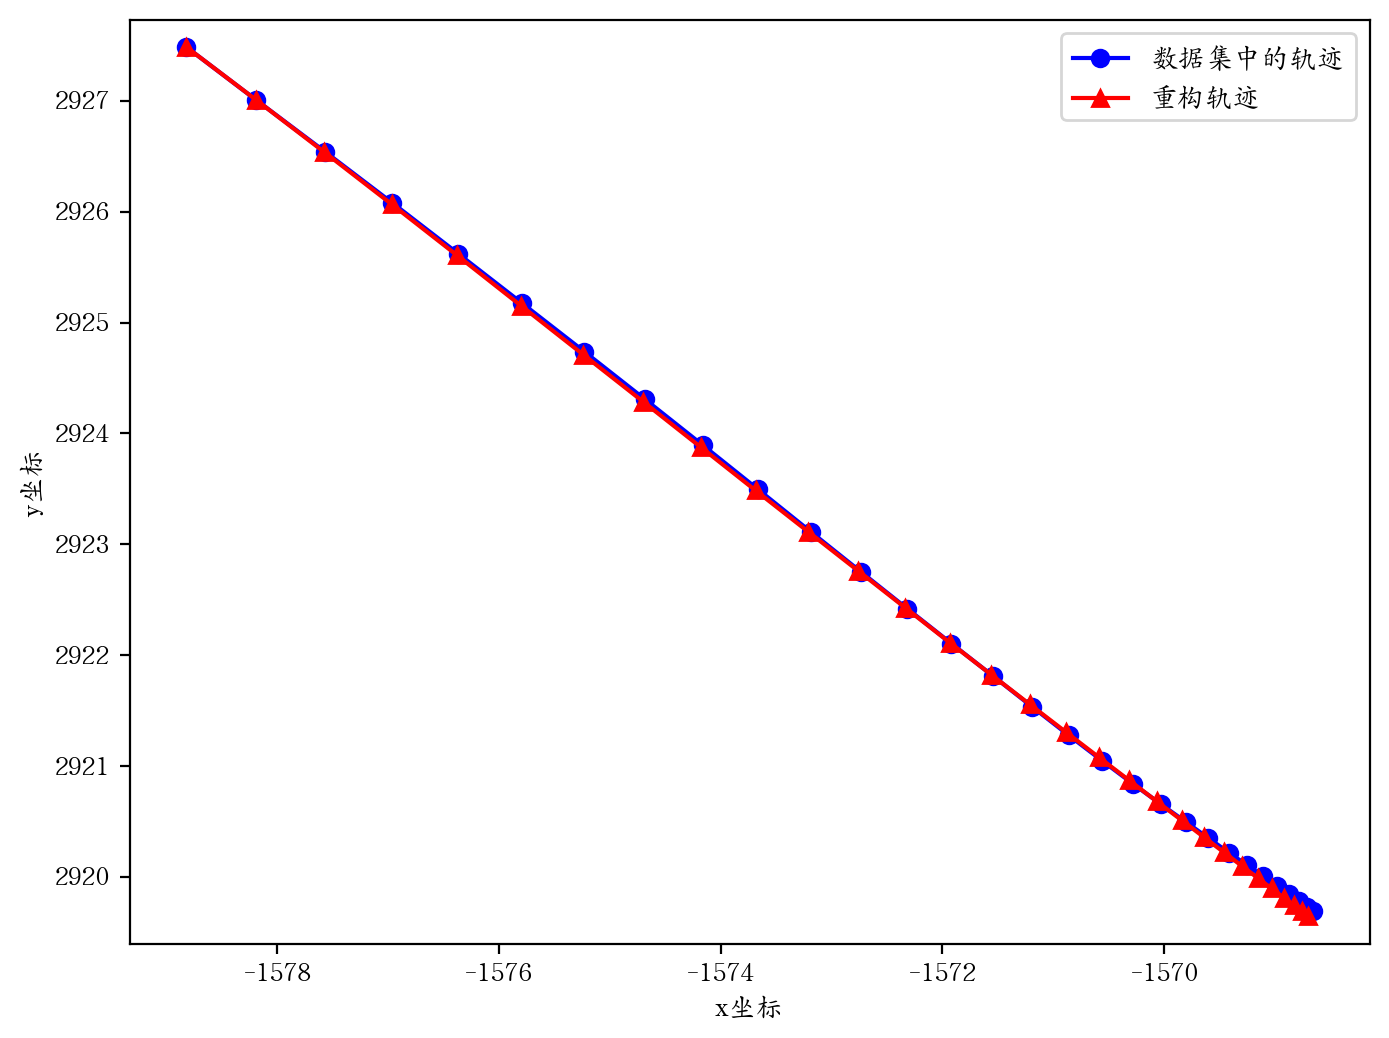

In [7]:
plt.figure(figsize=(8, 6),dpi=200)

plt.rcParams['font.sans-serif'] = ['AR PL UKai CN']  # 指定字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘制原始轨迹

# num = 845
num = np.random.randint(0,30000)
print(num)
# num = 29278
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='数据集中的轨迹')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '-^', c='red', label='重构轨迹')
# plt.title('Reconstructed Trajectory')
plt.xlabel('x坐标')
plt.ylabel('y坐标')
plt.legend()
plt.axis('equal')
plt.show()

# 用原始轨迹直接差分计算
xo = val_label.cpu().numpy()[num, :,0]
yo = val_label.cpu().numpy()[num, :,1]

plt.show()

In [8]:

# 定义专门用来重构轨迹的类, 计算误差ADE

class Reconstruct_Traj(Vehicle_Model_Methods):

    def __init__(self):
        super(Reconstruct_Traj, self).__init__()

    def ADE_err(self,out,label):
        ade = ((out - label) ** 2).sum(dim=2).sqrt().mean()
        return ade
    
    def AMDE_err(self,out,label):
        # 计算每个样本的误差
        error = ((out - label) ** 2).sum(dim=2).sqrt()
        # 提取最大值
        max_error, _ = error.max(dim=1)
        # 对最大值取平均
        amde = max_error.mean()
        return amde
    
    def calculate(self,actions,edagepoint,endstate,mode,labels):

        ax = actions[:,:,0]
        delta = actions[:,:,1]

        if mode == 'init_one':
            out = self.initial_unidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'init_two':
            out = self.initial_bidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'two_point':
            out,condtion = self.two_point_reconstruct(ax, delta, edagepoint, endstate)
        else:
            print(f'没有重构模式{mode}')
            out = torch.zeros(labels.shape, dtype=torch.float32, device=labels.device)
        
        loss_err1 = self.ADE_err(out,labels)
        loss_err1 = loss_err1.cpu().numpy()


        loss_err2 = self.AMDE_err(out,labels)
        loss_err2 = loss_err2.cpu().numpy()

        loss_err = [loss_err1,loss_err2]

        return loss_err

In [9]:
recon_tarj = Reconstruct_Traj()

err_init_one = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_one',val_label)
print('单点单向重构误差',err_init_one)

err_init_two = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_two',val_label)
print('单点双向重构误差',err_init_two)

# err_two_point = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'two_point',val_label)
# print('两点重构误差',err_two_point)


单点单向重构误差 [array(0.03696169, dtype=float32), array(0.09088541, dtype=float32)]
单点双向重构误差 [array(0.03976851, dtype=float32), array(0.0798494, dtype=float32)]
